In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import torch
import torch.nn as nn

data = pd.read_csv("AAPL_short_volume.csv")
data.head()

,Date,Short Vol,Short Exempt Vol,Total Vol,% Shorted,Close
0,18/07/2023,8974071.0,92762.0,19136383.0,46.90,193.729996
1,17/07/2023,9867747.0,77497.0,19106282.0,51.65,193.990005
2,14/07/2023,6363715.0,98141.0,15104938.0,42.13,190.690002
3,13/07/2023,6148358.0,66729.0,16166076.0,38.03,190.539993
4,12/07/2023,8580496.0,84584.0,21275653.0,40.33,189.770004


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
data = data[["Date", "Close"]]
data

,Date,Close
0,18/07/2023,193.729996
1,17/07/2023,193.990005
2,14/07/2023,190.690002
3,13/07/2023,190.539993
4,12/07/2023,189.770004
...,...,...
589,NaN,NaN
590,NaN,NaN
591,NaN,NaN
592,NaN,NaN


In [4]:
data.isnull().sum()

,0
Date,343
Close,343


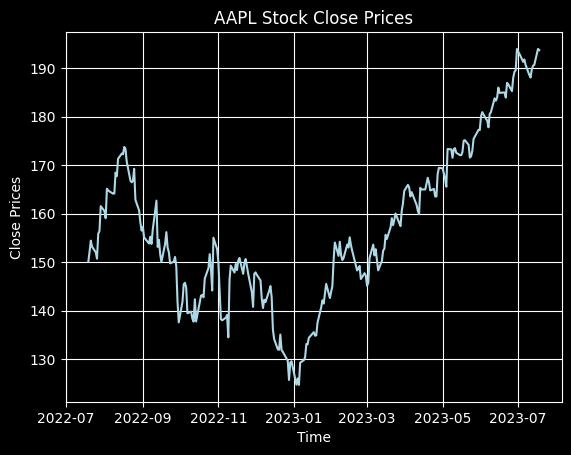

In [6]:
data['Date'] = pd.to_datetime(data["Date"],format="%d/%m/%Y")
plt.plot(data["Date"], data["Close"], color="lightblue")
plt.xlabel('Time')
plt.ylabel('Close Prices')
plt.title('AAPL Stock Close Prices')
plt.grid(True)
plt.show()

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2023-07-07,190.679993,188.610001,188.080002,189.770004,190.539993,190.690002,193.990005,193.729996
2023-07-06,191.809998,190.679993,188.610001,188.080002,189.770004,190.539993,190.690002,193.990005
2023-07-05,191.330002,191.809998,190.679993,188.610001,188.080002,189.770004,190.539993,190.690002
2023-07-03,192.460007,191.330002,191.809998,190.679993,188.610001,188.080002,189.770004,190.539993
2023-06-30,193.970001,192.460007,191.330002,191.809998,190.679993,188.610001,188.080002,189.770004
...,...,...,...,...,...,...,...,...
2022-07-25,152.042114,150.700165,155.859314,156.416016,161.545380,160.551315,159.060211,165.143890
2022-07-22,153.175354,152.042114,150.700165,155.859314,156.416016,161.545380,160.551315,159.060211
2022-07-21,154.427872,153.175354,152.042114,150.700165,155.859314,156.416016,161.545380,160.551315


In [8]:
shifted_df.isnull().sum()

,0
Close,0
Close(t-1),0
Close(t-2),0
Close(t-3),0
Close(t-4),0
Close(t-5),0
Close(t-6),0
Close(t-7),0


In [9]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[190.6799927, 188.6100006, 188.0800018, ..., 190.6900024,
        193.9900055, 193.7299957],
       [191.8099976, 190.6799927, 188.6100006, ..., 190.5399933,
        190.6900024, 193.9900055],
       [191.3300018, 191.8099976, 190.6799927, ..., 189.7700043,
        190.5399933, 190.6900024],
       ...,
       [154.4278717, 153.175354 , 152.0421143, ..., 156.4160156,
        161.5453796, 160.5513153],
       [152.1315765, 154.4278717, 153.175354 , ..., 155.859314 ,
        156.4160156, 161.5453796],
       [150.1036835, 152.1315765, 154.4278717, ..., 150.7001648,
        155.859314 , 156.4160156]])

In [10]:
shifted_df_as_np.shape

(244, 8)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.90506809,  0.84533928,  0.83004638, ...,  0.90535692,
         1.        ,  0.99249968],
       [ 0.93767394,  0.90506809,  0.84533928, ...,  0.90102847,
         0.90480718,  1.        ],
       [ 0.92382385,  0.93767394,  0.90506809, ...,  0.87881074,
         0.90047997,  0.90480718],
       ...,
       [-0.14097265, -0.17711356, -0.20981275, ..., -0.08360554,
         0.06409314,  0.03541808],
       [-0.20723135, -0.14097265, -0.17711356, ..., -0.09966895,
        -0.08386994,  0.06409314],
       [-0.26574541, -0.20723135, -0.14097265, ..., -0.24853418,
        -0.09992871, -0.08386994]])

In [12]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((244, 7), (244,))

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.99249968,  1.        ,  0.90535692, ...,  0.87881074,
         0.83004638,  0.84533928],
       [ 1.        ,  0.90480718,  0.90102847, ...,  0.83004638,
         0.84533928,  0.90506809],
       [ 0.90480718,  0.90047997,  0.87881074, ...,  0.84533928,
         0.90506809,  0.93767394],
       ...,
       [ 0.03541808,  0.06409314, -0.08360554, ..., -0.24853418,
        -0.20981275, -0.17711356],
       [ 0.06409314, -0.08386994, -0.09966895, ..., -0.20981275,
        -0.17711356, -0.14097265],
       [-0.08386994, -0.09992871, -0.24853418, ..., -0.17711356,
        -0.14097265, -0.20723135]])

In [16]:
split_index = int(len(X) * 0.95)

split_index

231

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((231, 7), (13, 7), (231,), (13,))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((231, 7, 1), (13, 7, 1), (231, 1), (13, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([231, 7, 1]),
 torch.Size([13, 7, 1]),
 torch.Size([231, 1]),
 torch.Size([13, 1]))

In [20]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [21]:
train_dataset

In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [26]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [37]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.012
***************************************************

Epoch: 2

Val Loss: 0.016
***************************************************

Epoch: 3

Val Loss: 0.012
***************************************************

Epoch: 4

Val Loss: 0.015
***************************************************

Epoch: 5

Val Loss: 0.011
***************************************************

Epoch: 6

Val Loss: 0.015
***************************************************

Epoch: 7

Val Loss: 0.012
***************************************************

Epoch: 8

Val Loss: 0.013
***************************************************

Epoch: 9

Val Loss: 0.013
***************************************************

Epoch: 10

Val Loss: 0.013
***************************************************

Epoch: 11

Val Loss: 0.014
***************************************************

Epoch: 12

Val Loss: 0.010
***************************************************

Epoch: 13

Val Loss: 0.012
**********************

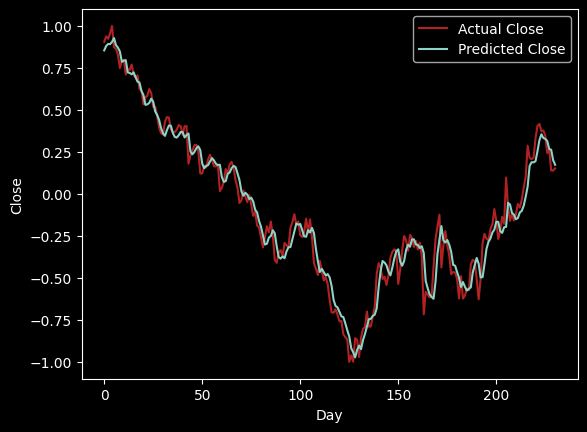

In [38]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close',color="firebrick")
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [39]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([188.93360783, 189.82241801, 190.25348184, 190.21227754,
       190.67432878, 191.47522117, 189.99646056, 189.50483279,
       188.69220523, 186.57562185, 186.80573547, 186.91288688,
       184.39561769, 184.26664021, 183.99162058, 184.3872248 ,
       183.38281041, 182.47989778, 182.2873012 , 180.58618778,
       179.72705949, 177.68647487, 177.78561555, 178.09916234,
       178.95582007, 178.32900948, 176.34183119, 175.61310261,
       174.57412718, 172.88418397, 171.8148553 , 171.28698709,
       172.4843234 , 173.43218026, 173.37437918, 171.90350538,
       171.07149649, 170.93763261, 171.4140187 , 172.07559896,
       172.08218644, 170.96363137, 171.4687264 , 171.77350021,
       168.0504099 , 167.48379814, 167.96855801, 168.73851773,
       169.13838347, 168.38803952, 165.56648144, 164.6176031 ,
       165.09393496, 165.24712284, 166.04706242, 166.70175258,
       166.21959858, 165.52265269, 165.25930627, 165.34025545,
       162.7901573 , 161.79421482, 161.95151419, 163.47

In [40]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([190.6799929 , 191.80999704, 191.33000117, 192.46000738,
       193.9700012 , 189.58999702, 189.24999908, 188.059997  ,
       185.27000523, 186.67999285, 186.99999905, 183.96000728,
       185.0099949 , 184.91999903, 186.00999491, 183.94999695,
       183.30999694, 183.78999282, 180.96000724, 180.57000724,
       177.8200072 , 179.21000722, 179.58000103, 180.94999691,
       180.0899969 , 177.250001  , 177.30000307, 175.42999272,
       172.99000508, 171.8399968 , 171.55999783, 174.19999683,
       175.16000407, 175.05000304, 172.69000198, 172.07000714,
       172.07000714, 172.57000714, 173.51001025, 173.32026639,
       171.5327452 , 173.26034592, 173.33026123, 165.56098929,
       167.21870414, 168.30718949, 169.35574352, 169.44561751,
       168.17738366, 163.53379809, 163.54379267, 165.10163895,
       164.79206861, 166.41979998, 167.39846814, 166.24006645,
       165.00177012, 164.98181143, 165.33131412, 159.87886053,
       160.57789612, 161.80618291, 164.4325561 , 163.53

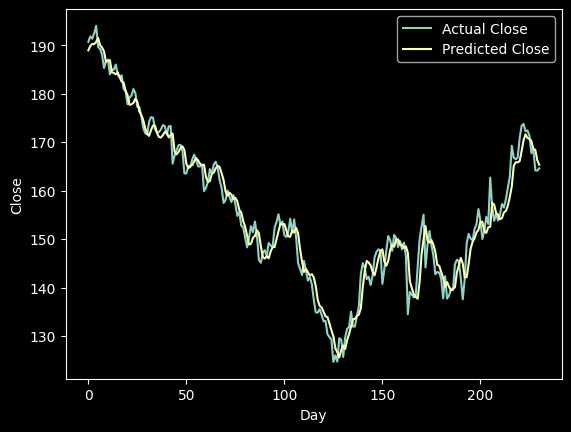

In [41]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [42]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([165.24328169, 165.26093403, 165.29941059, 162.27556295,
       161.3735547 , 161.61247525, 159.04636423, 157.22806908,
       153.29958035, 152.00327843, 151.93966089, 152.71237883,
       152.11606866])

In [43]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([164.82579046, 165.14389055, 159.06021119, 160.55131535,
       161.54537961, 156.41601552, 155.8593139 , 150.70016491,
       152.04211442, 153.17535395, 154.42787152, 152.1315763 ,
       150.1036838 ])

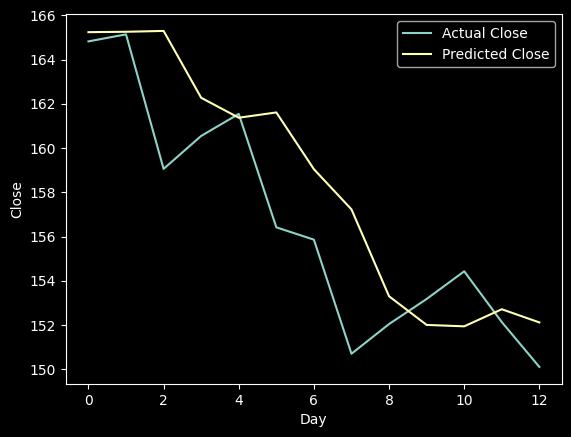

In [44]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()